In [105]:
import numpy as np
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b
import scipy.optimize as opt

In [106]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [113]:
a1, a2 = 0.9,0.9
a3 = a1*a2
print((b1(a1)-b2(a1))/b1(a1))
print((b1(a2)-b2(a2))/b1(a2))
print((b1(a3)-b2(a3))/b1(a3))

0.03398057807120855
0.03398057807120855
0.09427123769544492


In [62]:
def Mprime(alpha, mass):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    alpha12, alpha23, alpha13 = alpha
    
    R = np.array([[np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)],
             [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
             [np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)]])
       
    M = np.array([[b1(alpha12)*m2+b1(alpha13)*m3, -b2(alpha12)*np.sqrt(m1*m2), -b2(alpha13)*np.sqrt(m1*m3)],
             [-b2(alpha12)*np.sqrt(m1*m2), b1(alpha12)*m1+ b1(alpha23)*m3, -b2(alpha23)*np.sqrt(m2*m3)],
             [-b2(alpha13)*np.sqrt(m1*m3), -b2(alpha23)*np.sqrt(m2*m3), b1(alpha13)*m1+b1(alpha23)*m2]])*(-2*alpha[2])*np.pi/4
    
    return np.matmul(np.matmul(R, M), np.transpose(R))

In [63]:
Mprime((0.91, 0.91, 0.91*0.91),(1e-7,1e-100,1e-7))

array([[-2.38739561e-07,  6.87201531e-23,  8.21361167e-54],
       [ 4.88573067e-22, -5.68146454e-06,  1.69672831e-68],
       [ 8.21361167e-54,  8.34254456e-69, -2.11764459e-05]])

$$ R \cdot \begin{pmatrix}\vec{G_1}\\ \vec{G_2}\\ \vec{G_3} \end{pmatrix} = \begin{pmatrix}\vec{S_1}\\ \vec{S_2}\\ \vec{S_3} \end{pmatrix} $$

In [64]:
def StoG(mass, amp, phi):
    m1, m3 = mass
    A1, A2, A3 = amp
    p1, p2, p3 = phi
    
    e1_x = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.cos(p1) - np.sqrt(m3/(m1+m3))*A2*np.cos(p2))
    e2_x = 1/np.sqrt(m1+m3)*A1*np.cos(p1) - A3*np.cos(p3)
    e3_x = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.cos(p1) + np.sqrt(m1/(m1+m3))*A2*np.cos(p2))
    
    e1_y = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.sin(p1) - np.sqrt(m3/(m1+m3))*A2*np.sin(p2))
    e2_y = 1/np.sqrt(m1+m3)*A1*np.sin(p1) - A3*np.sin(p3)
    e3_y = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.sin(p1) + np.sqrt(m1/(m1+m3))*A2*np.sin(p2))
    
    e1, e2, e3 = np.sqrt(e1_x**2 + e1_y**2), np.sqrt(e2_x**2 + e2_y**2), np.sqrt(e3_x**2 + e3_y**2)
    pom1, pom2, pom3 = np.arctan2(e1_y,e1_x), np.arctan2(e2_y,e2_x), np.arctan2(e3_y,e3_x)
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [65]:
def GtoS(alpha, mass, ecc, pomega):
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    m1, m3 = mass
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pomega

    e1_x, e2_x, e3_x = ecc1*np.cos(pom1), ecc2*np.cos(pom2), ecc3*np.cos(pom3)
    e1_y, e2_y, e3_y = ecc1*np.sin(pom1), ecc2*np.sin(pom2), ecc3*np.sin(pom3)
    
    amp1 = 1/np.sqrt(m1+m3) * np.sqrt((m1*e1_y + m3*e3_y)**2 + (m1*e1_x + m3*e3_x)**2)
    amp2 = np.sqrt(m1*m3/(m1+m3)) * np.sqrt((e3_y-e1_y)**2 + (e3_x-e1_x)**2)
    amp3 = 1/(m1+m3) * np.sqrt((m3*(e3_y-e2_y)-m1*(e2_y-e1_y))**2+(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))**2)
    
    phase1 = np.arctan2(m1*e1_y+m3*e3_y, m1*e1_x+m3*e3_x)
    phase2 = np.arctan2(e3_y-e1_y, e3_x-e1_x)
    phase3 = np.arctan2(m3*(e3_y-e2_y)-m1*(e2_y-e1_y), m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    
    omega2 = (alpha12+alpha13+alpha23)/3 * (m1+m3)/(2*(1-alpha13)**2)
    omega3 = (alpha12+alpha13+alpha23)/3 * (m1/(2*(1-alpha12)**2) + m3/(2*(1-alpha23)**2))
    
    return amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3

In [66]:
# set A2 to zero
def breathingON1(mass, A3_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/(m1*(m1+m3)))
    x2 = 1
    y1 = np.sqrt(m1/(m3*(m1+m3)))
    y2 = 1

    if m1==m3:
        A3_b = A3_p / np.sqrt(2)
        A2_b = A3_b*x2/x1
        theta = np.pi/2
    else:
        def A2(theta):
            return np.fabs(2*A3_p*x2*y2*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def A3(theta):
            return np.fabs(A3_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [67]:
# set A3 to zero
def breathingON2(mass, A2_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/(m1*(m1+m3)))
    x2 = 1
    y1 = np.sqrt(m1/(m3*(m1+m3)))
    y2 = 1

    if m1==m3:
        A2_b = A2_p / np.sqrt(2)
        A3_b = A2_b*x1/x2
        theta = np.pi/2
    else:
        def A2(theta):
            return np.fabs(A2_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def A3(theta):
            return np.fabs(2*A2_p*x1*y1*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [71]:
def plotEcc(alpha, mass, ecc, pomega, time):
    m1, m3 = mass
    A1, A2, A3, p1, p2, p3, w2, w3 = GtoS(alpha, mass, ecc, pomega)
    print(f"A1={A1},A2={A2},A3={A3}")
    print(f"w2={w2},w3={w3}")
    
    t = np.linspace(0,time,400)
    
    e1_x = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.cos(p1) - np.sqrt(m3/(m1+m3))*A2*np.cos(w2*t+p2))
    e2_x = 1/np.sqrt(m1+m3)*A1*np.cos(p1) - A3*np.cos(w3*t+p3)
    e3_x = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.cos(p1) + np.sqrt(m1/(m1+m3))*A2*np.cos(w2*t+p2))
    
    e1_y = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.sin(p1) - np.sqrt(m3/(m1+m3))*A2*np.sin(w2*t+p2))
    e2_y = 1/np.sqrt(m1+m3)*A1*np.sin(p1) - A3*np.sin(w3*t+p3)
    e3_y = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.sin(p1) + np.sqrt(m1/(m1+m3))*A2*np.sin(w2*t+p2))
    
    e1 = np.sqrt(e1_x**2 + e1_y**2)
    e2 = np.sqrt(e2_x**2 + e2_y**2)
    e3 = np.sqrt(e3_x**2 + e3_y**2)
    
    e21 = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
    e32 = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
    
    fig, axarr = plt.subplots(nrows=5, figsize=(5,4))
    axarr[0].plot(t, e1, 'k.')
    axarr[0].set_ylabel(r"$e_{1}$")
    
    axarr[1].plot(t, e2, 'k.')
    axarr[1].set_ylabel(r"$e_{2}$")
    
    axarr[2].plot(t, e3, 'k.')
    axarr[2].set_ylabel(r"$e_{3}$")
    
    axarr[3].plot(t, e21, 'k.')
    axarr[3].set_ylabel(r"$e_{21}$")
    
    axarr[4].plot(t, e32, 'k.')
    axarr[4].set_ylabel(r"$e_{32}$")
    

In [99]:
alpha = 0.91,0.87
mass = 1e-7,1e-7
ecc = 0.4*(1-0.91), 0.4*(1-(0.91+0.87)/2), 0.4*(1-0.87)
pomega = 0, 2*np.pi/3, -2*np.pi/3

A1=1.0315037566582107e-05,A2=0.0,A3=0.06636264009214823
w2=1.9756977727094053e-06,w3=7.827757079893835e-06


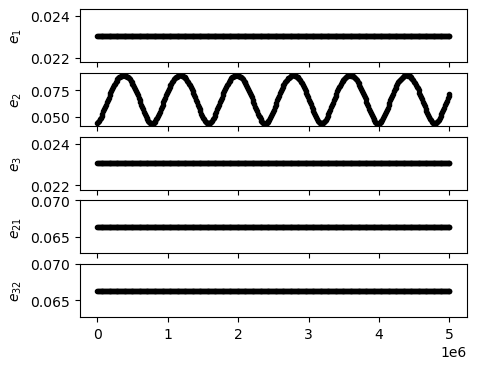

In [100]:
amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3 = GtoS(alpha, mass, ecc, pomega)
ecc, pomega = StoG(mass, (amp1, 0, amp3), (phase1, phase2, phase3))
plotEcc(alpha, mass, ecc, pomega,5e6)

A1=1.0315037566582107e-05,A2=2.0985709423319477e-05,A3=0.04692547282660026
w2=1.9756977727094053e-06,w3=7.827757079893835e-06


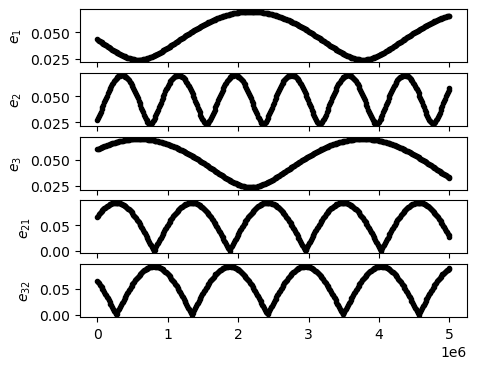

In [101]:
A2, A3, theta = breathingON1(mass,amp3)
ecc, pomega = StoG(mass, (amp1, A2, A3), (phase1, phase2, phase2+theta))
plotEcc(alpha, mass, ecc, pomega, 5e6)

In [102]:
alpha = 0.87,0.91
mass = 1e-7,1e-7
ecc = 0.4*(1-0.87), 0.4*(1-(0.91+0.87)/2), 0.4*(1-0.91)
pomega = 0, 2*np.pi/3, -2*np.pi/3

A1=1.0315037566582102e-05,A2=0.0,A3=0.06636264009214822
w2=1.9756977727094053e-06,w3=7.827757079893835e-06


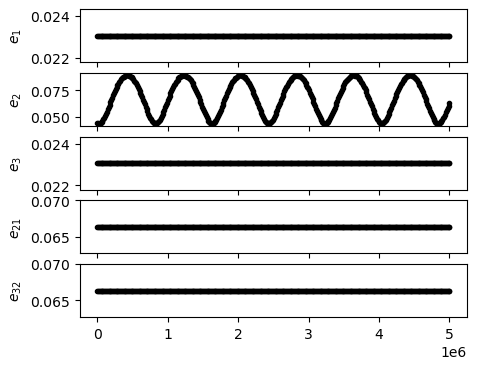

In [103]:
amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3 = GtoS(alpha, mass, ecc, pomega)
ecc, pomega = StoG(mass, (amp1, 0, amp3), (phase1, phase2, phase3))
plotEcc(alpha, mass, ecc, pomega,5e6)

A1=1.0315037566582105e-05,A2=2.098570942331947e-05,A3=0.04692547282660026
w2=1.9756977727094053e-06,w3=7.827757079893835e-06


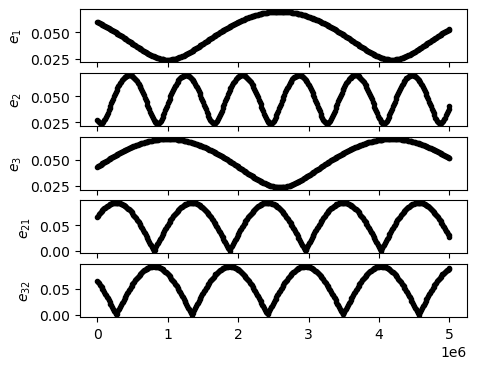

In [104]:
A2, A3, theta = breathingON1(mass,amp3)
ecc, pomega = StoG(mass, (amp1, A2, A3), (phase1, phase2, phase2+theta))
plotEcc(alpha, mass, ecc, pomega, 5e6)